## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE

## Load Data

In [2]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Separating Feature and Target Variables

In [3]:
X = df.drop(columns=['Class','Time'])   
y = df['Class']

## Train-test split (stratify to preserve imbalance)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Scale 'Amount' and other numeric non-PCA columns

In [5]:
scaler = StandardScaler()
X_train['Amount'] = scaler.fit_transform(X_train[['Amount']])
X_test['Amount'] = scaler.transform(X_test[['Amount']])

## Handle imbalance - two approaches shown
 Approach A: Use class_weight in model (no resampling)

 Approach B: Use SMOTE on train set

In [6]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [7]:
print('Before SMOTE:', y_train.sum(), '/', len(y_train))
print('After SMOTE:', y_train_sm.sum(), '/', len(y_train_sm))

Before SMOTE: 394 / 227845
After SMOTE: 227451 / 454902


## Baseline Logistic Regression with class_weight

In [8]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]
print('LR ROC-AUC:', roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

LR ROC-AUC: 0.9713857194537916
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



## Random Forest on SMOTE data

In [9]:
rf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]
print('RF ROC-AUC:', roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

RF ROC-AUC: 0.982056004731662
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.54      0.85      0.66        98

    accuracy                           1.00     56962
   macro avg       0.77      0.92      0.83     56962
weighted avg       1.00      1.00      1.00     56962



## Confusion matrix at chosen threshold

In [10]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
pr_auc = auc(recall, precision)
print('RF PR-AUC:', pr_auc)

RF PR-AUC: 0.8244652375462486


## Confusion matrix at chosen threshold

Text(0.5, 1.0, 'Random Forest Confusion Matrix (th=0.5)')

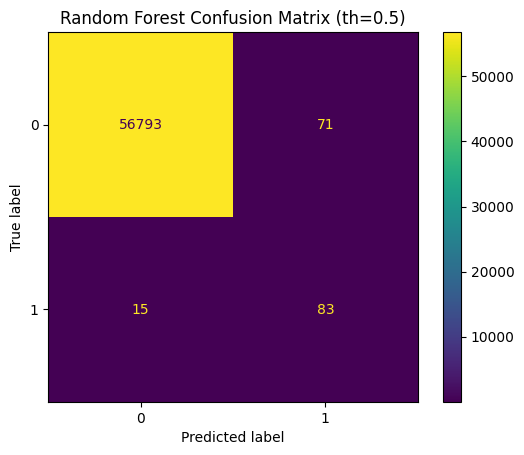

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

thresh = 0.5
cm = confusion_matrix(y_test, (y_proba_rf > thresh).astype(int))
ConfusionMatrixDisplay(cm).plot()
plt.title('Random Forest Confusion Matrix (th=0.5)')

## Feature importance

In [12]:
importances = rf.feature_importances_
feat_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)
print(feat_df.head(15))

   feature  importance
13     V14    0.167015
9      V10    0.158479
3       V4    0.122251
11     V12    0.106296
10     V11    0.078249
16     V17    0.070984
6       V7    0.041904
2       V3    0.040184
15     V16    0.032379
1       V2    0.020939
8       V9    0.018739
17     V18    0.014400
20     V21    0.014181
7       V8    0.013406
4       V5    0.010923


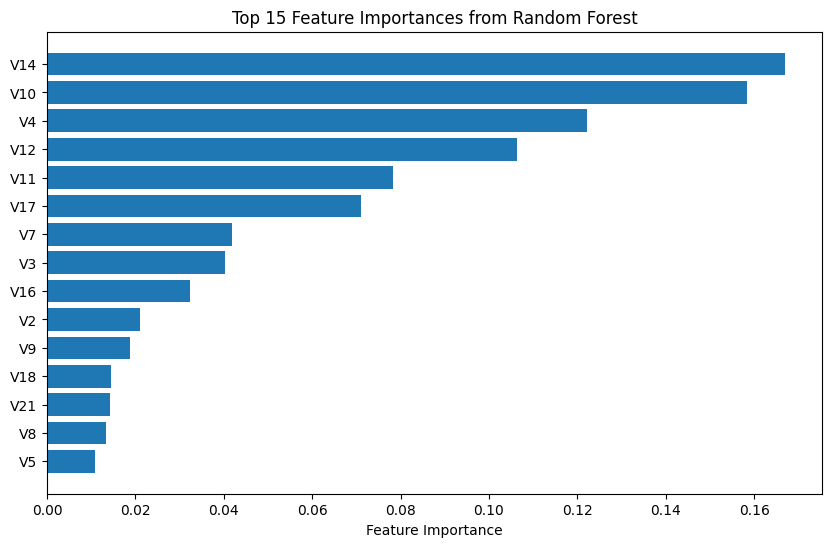

In [13]:
plt.figure(figsize=(10,6))
plt.barh(feat_df['feature'][:15], feat_df['importance'][:15])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

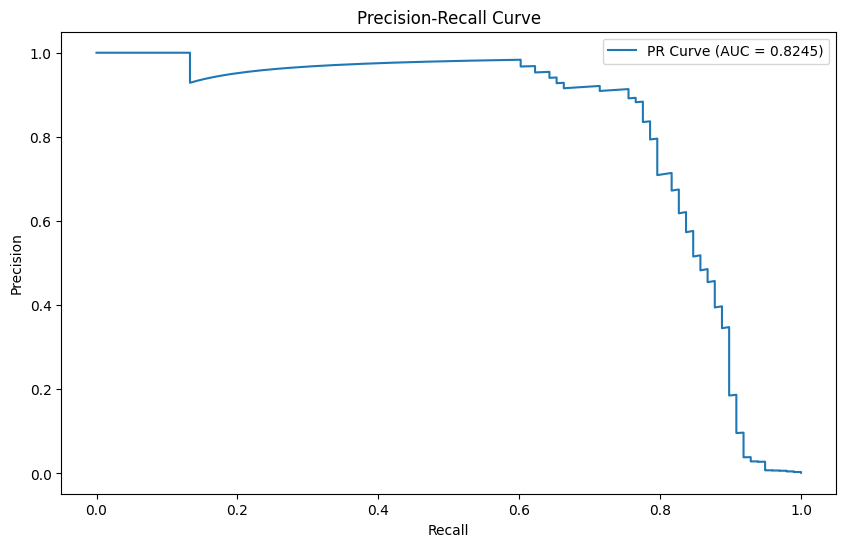

In [14]:
plt.figure(figsize=(10,6))  
plt.plot(recall, precision, label='PR Curve (AUC = {:.4f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

**Interpretation:**

- The model effectively distinguishes between fraudulent and legitimate transactions (AUC = 0.982).

- It detects **85% of all frauds** while keeping **precision at 54%**, meaning more than half of flagged transactions are actual frauds.

- Such a trade-off is optimal for **high-risk financial systems**, where catching more frauds is more valuable than minimizing false alerts.

- Business impact: Early detection could **reduce financial loss by up to 85%**, improving fraud investigation efficiency.

Text(0.5, 1.0, 'Precision-Recall Curve')

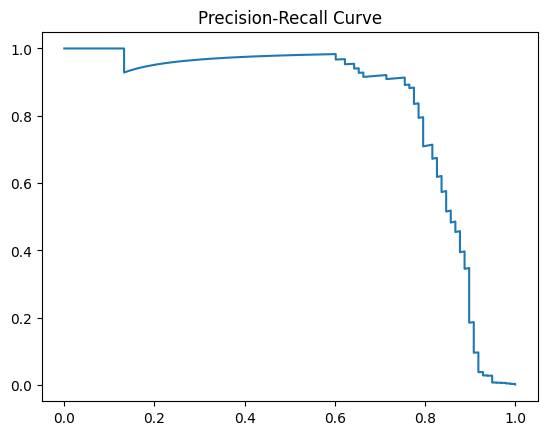

In [18]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rf)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')